In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import string
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Source
from IPython.display import SVG
from prettytable import PrettyTable


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


from nltk.stem.porter import PorterStemmer

import re
import nltk
from nltk.corpus import stopwords


from tqdm import tqdm

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix



In [2]:
con = sqlite3.connect('./final_review_data_set.db')
review_data = pd.read_sql_query("select * from Review",con)

review_data.shape , display(review_data.head()) , review_data.isna().any()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",junei saw charming groupof roses beginto droop...
1,1,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,fun way children learn months year learn poems...
2,2,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",grew reading sendak books watching really rosi...
3,3,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,get movie sound track sing along carol king gr...
4,4,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,entertaining rhyming story cleaver catchy illu...


((393931, 11),
 None,
 index                     False
 Id                        False
 ProductId                 False
 UserId                    False
 ProfileName               False
 HelpfulnessNumerator      False
 HelpfulnessDenominator    False
 Score                     False
 Time                      False
 Summary                   False
 Text                      False
 dtype: bool)

In [3]:
X_data = review_data.drop(['Score'],axis=1)
y_data = review_data['Score']

In [4]:
count_vect = CountVectorizer(min_df=0.01)
X_bow = count_vect.fit_transform(X_data['Text'].values)
X_bow

<393931x632 sparse matrix of type '<class 'numpy.int64'>'
	with 7841554 stored elements in Compressed Sparse Row format>

In [5]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(min_df=0.01)
x_tfidf = tf_idf_vect.fit_transform(X_data['Text'].values)

In [6]:
textsplits = [text.split() for text in X_data['Text'].values]
len(textsplits)

393931

In [7]:
w2v_model = Word2Vec(textsplits,min_count=10,vector_size=65)
X_w2v = w2v_model.wv.key_to_index.keys()


In [8]:
w2v_words = list(X_w2v)
list_vectors = []

for text in tqdm(textsplits):
    count_words = 0
    text_vec = np.zeros(65)
    
    for w in text:

        if w in w2v_words:
            count_words += 1
            vec = w2v_model.wv[w]
            text_vec += vec

    if count_words != 0:
        text_vec /= count_words

    list_vectors.append(text_vec)

print(len(list_vectors))
print(len(list_vectors[0]))



100%|██████████| 393931/393931 [03:18<00:00, 1980.63it/s]

393931
65


In [9]:
X_w2v = np.array(list_vectors)
X_w2v.shape

(393931, 65)

In [10]:
# tfidf - word2vec
tf_idf_model = TfidfVectorizer()
tf_idf_matrix = tf_idf_model.fit_transform(X_data['Text'].values)
mapped_data = dict(zip(tf_idf_model.get_feature_names_out(), list(tf_idf_model.idf_)))
# mapped_data

In [11]:
# TF-IDF weighted Word2Vec

tfidf_text_vectors = []

for text in tqdm(textsplits):
    weight_sum = 0 
    text_vec = np.zeros(65)

    for w in text: 
        if w in w2v_words and len(w) != 1:
            vec = w2v_model.wv[w]
            data = mapped_data[w]*(text.count(w)/len(text))
            text_vec += (vec * data)
            weight_sum += data

    if weight_sum != 0:
        text_vec /= weight_sum
        
    tfidf_text_vectors.append(text_vec)


100%|██████████| 393931/393931 [03:57<00:00, 1660.28it/s]


In [12]:
X_tfw2v = np.array(tfidf_text_vectors)


In [13]:
# decision tree

In [14]:
# split the dataset
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_data, test_size=0.1, random_state=234)

In [15]:
# initializing DecisionTreeClassifier model
decision_tree_model = DecisionTreeClassifier()

parameters = {'max_depth':[1, 10, 30, 50, 100],
              'min_samples_split':[5, 10, 30, 50, 100]}

In [16]:

# using GridSearchCV 
grid_search = GridSearchCV(decision_tree_model,parameters,scoring='roc_auc',cv=10,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_bow,y_train_bow)
print("best max depth :",grid_search.best_params_['max_depth'])
print("best min sample split :",grid_search.best_params_['min_samples_split'])
print("best roc auc score : %.3f"%(grid_search.best_score_))

best max depth : 30
best min sample split : 100
best roc auc score : 0.785


In [17]:
best_max_depth = grid_search.best_params_['max_depth']
best_min_sample_split = grid_search.best_params_['min_samples_split']

decisiontree_model_final = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_sample_split)
decisiontree_model_final.fit(X_train_bow,y_train_bow)

y_pred = decisiontree_model_final.predict_proba(X_test_bow)[:,1]

auc_score = roc_auc_score(y_test_bow, y_pred)
print("\n Roc_Auc_Score on test set is " ,(auc_score))


 Roc_Auc_Score on test set is  0.7874755988090061


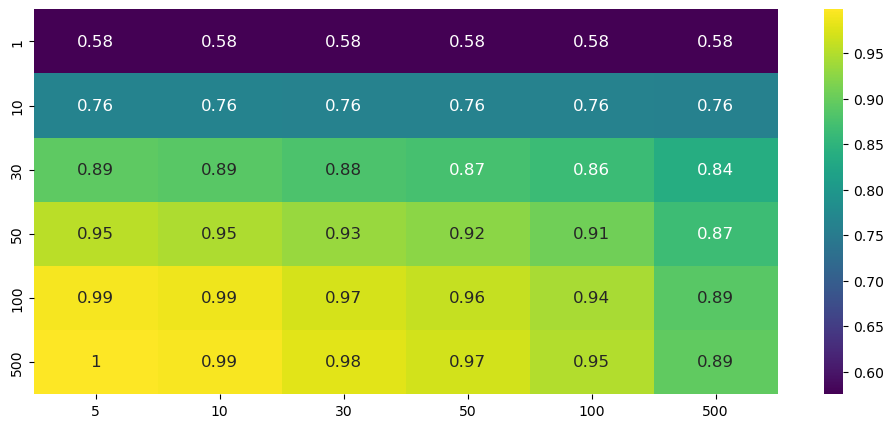

In [18]:
# train data
mean_score=np.array(grid_search.cv_results_['mean_train_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

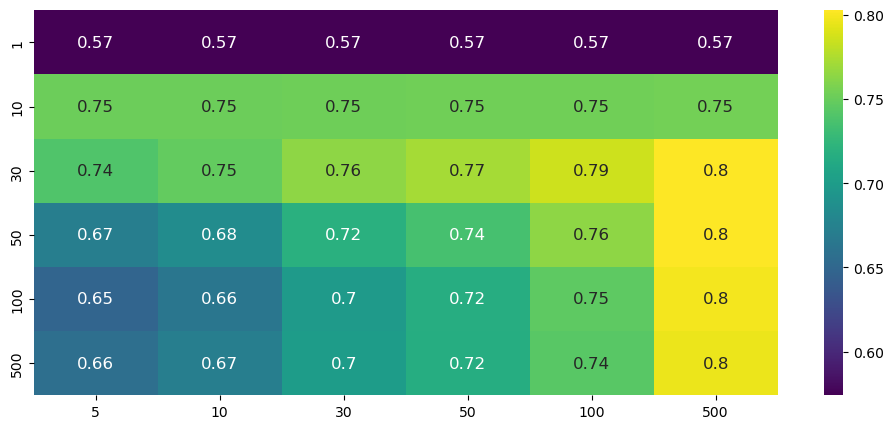

In [19]:
# test data
mean_score=np.array(grid_search.cv_results_['mean_test_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

[[ 17115  34176]
 [  8569 294677]]


<Axes: >

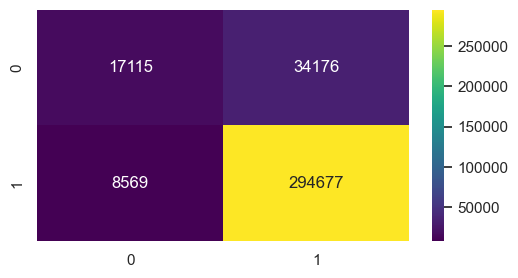

In [20]:
# confusion matrix of trained set
y_predict = decisiontree_model_final.predict(X_train_bow)
cm = confusion_matrix(y_train_bow, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

[[ 1617  4199]
 [ 1269 32309]]


<Axes: >

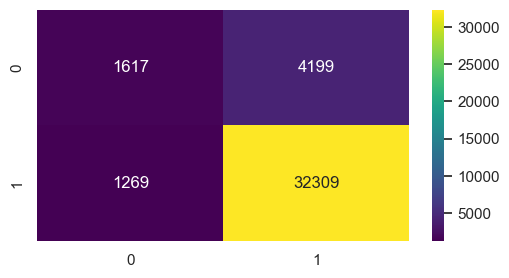

In [21]:
# confusion matrix of test set
y_predict = decisiontree_model_final.predict(X_test_bow)
cm = confusion_matrix(y_test_bow, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

In [22]:
#roc

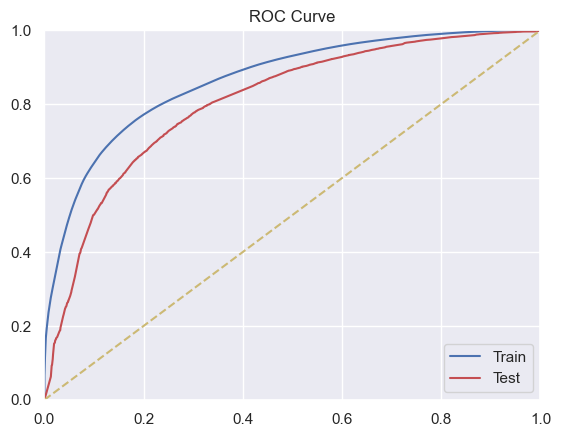

In [23]:
# Plotting roc curve on Train Data
y_predict_train = decisiontree_model_final.predict_proba(X_train_bow)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_bow, y_predict_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
y_predict_test = decisiontree_model_final.predict_proba(X_test_bow)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_bow, y_predict_test)
plt.plot(fpr, tpr, 'r', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'y--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

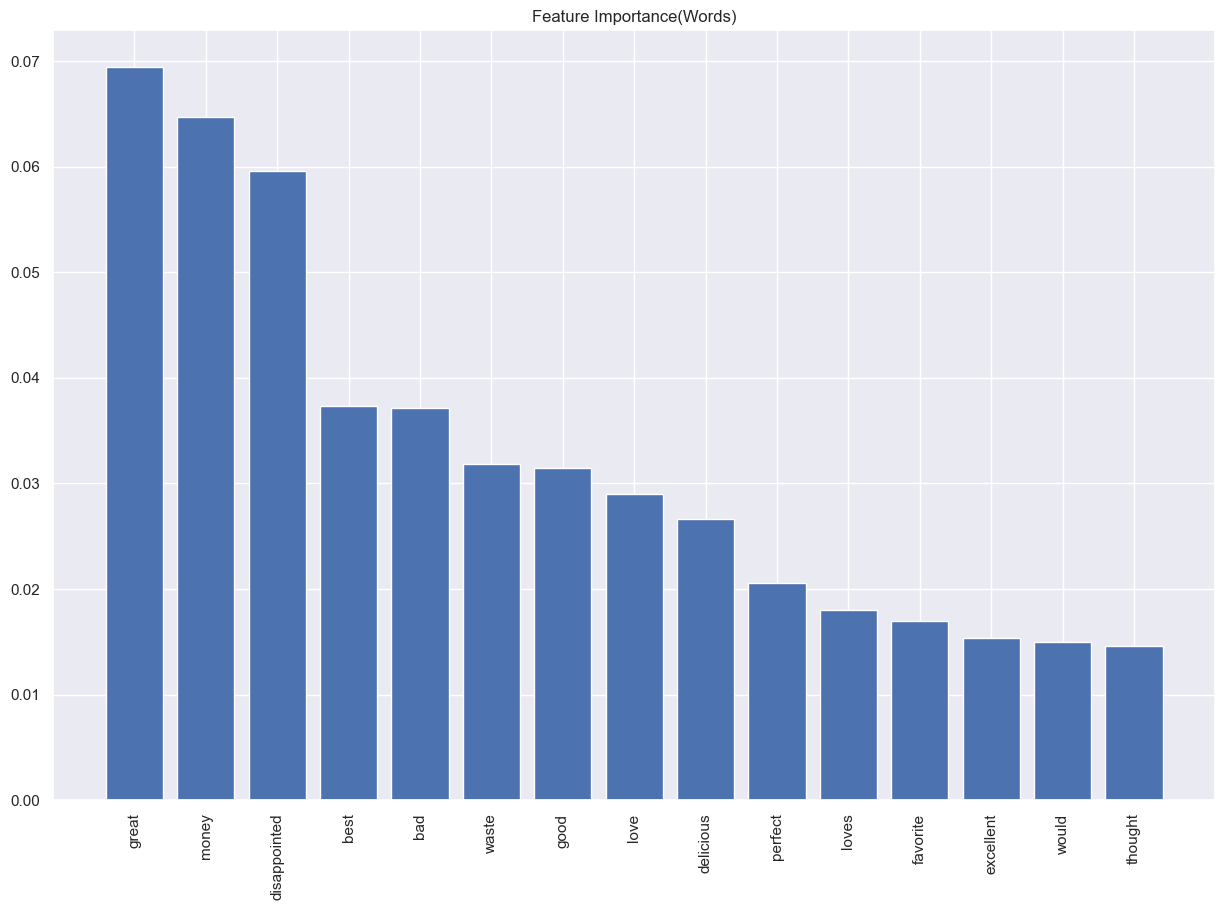

In [24]:

# Calculate feature importances 
feature_importances = decisiontree_model_final.feature_importances_
indices = np.argsort(feature_importances,kind='quicksort')[::-1][:15]
# Get the feature names 
feature_names = count_vect.get_feature_names_out()

sns.set(rc={'figure.figsize':(15,10)})
# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance(Words)")
# Add bars
plt.bar(range(15), feature_importances[indices])
# Add feature feature_names as x-axis labels
feature_names = np.array(feature_names)
plt.xticks(range(15), feature_names[indices], rotation=90)
# Show plot
plt.show()

In [25]:
# split the dataset
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    x_tfidf, y_data, test_size=0.1, random_state=234)

In [26]:

# using GridSearchCV 
grid_search = GridSearchCV(decision_tree_model,parameters,scoring='roc_auc',cv=10,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_tfidf,y_train_tfidf)
print("best max depth :",grid_search.best_params_['max_depth'])
print("best min sample split :",grid_search.best_params_['min_samples_split'])
print("best roc auc score : %.3f"%(grid_search.best_score_))

KeyboardInterrupt: 

In [29]:
best_max_depth = grid_search.best_params_['max_depth']
best_min_sample_split = grid_search.best_params_['min_samples_split']

decisiontree_model_final = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_sample_split)
decisiontree_model_final.fit(X_train_tfidf,y_train_tfidf)

y_pred = decisiontree_model_final.predict_proba(X_test_tfidf)[:,1]

auc_score = roc_auc_score(y_test_tfidf, y_pred)
print("\n Roc_Auc_Score on test set is " ,(auc_score))


**** Test roc_auc_score is 0.771903 ****


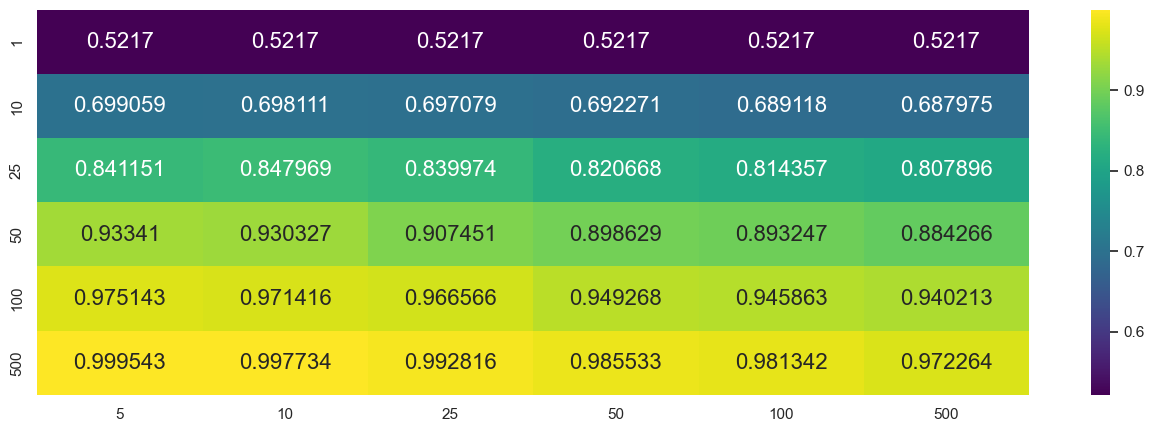

In [30]:
# train data
mean_score=np.array(grid_search.cv_results_['mean_train_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

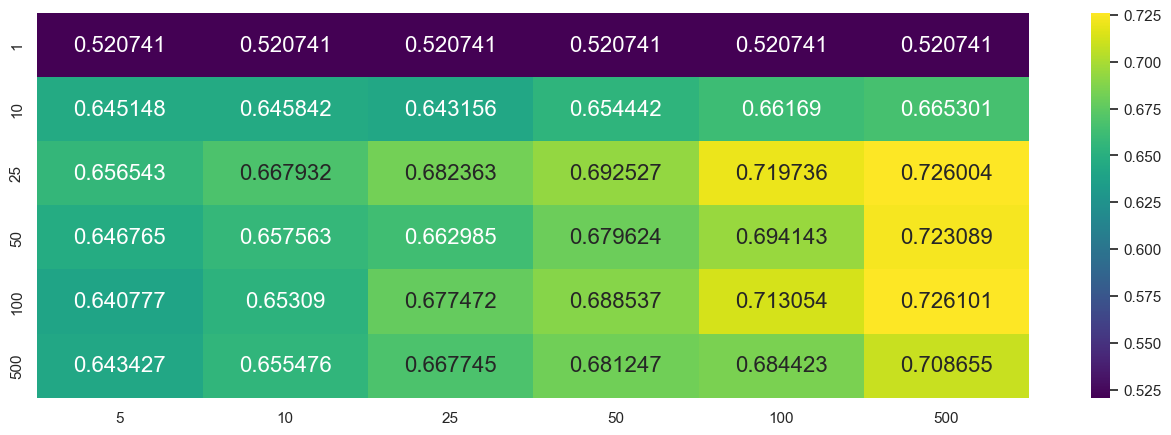

In [31]:
# test data
mean_score=np.array(grid_search.cv_results_['mean_test_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

[[ 784  628]
 [ 260 8362]]


<Axes: >

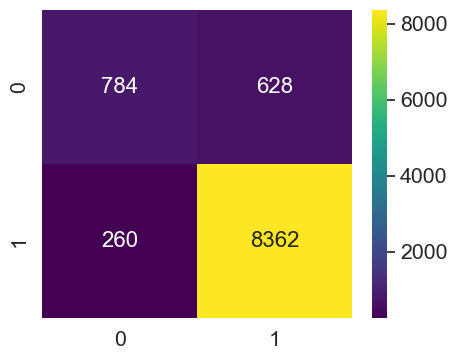

In [34]:
# confusion matrix of trained set
y_predict = decisiontree_model_final.predict(X_train_tfidf)
cm = confusion_matrix(y_train_tfidf, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

[[ 50 104]
 [ 58 903]]


<Axes: >

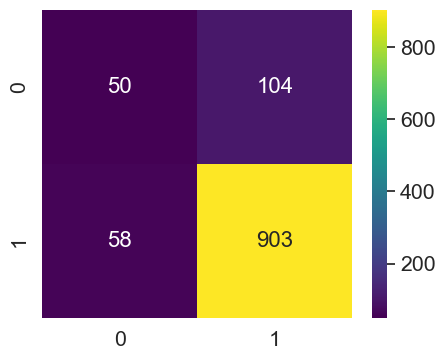

In [33]:
# confusion matrix of test set
y_predict = decisiontree_model_final.predict(X_test_tfidf)
cm = confusion_matrix(y_test_tfidf, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

In [35]:
# ROC curve

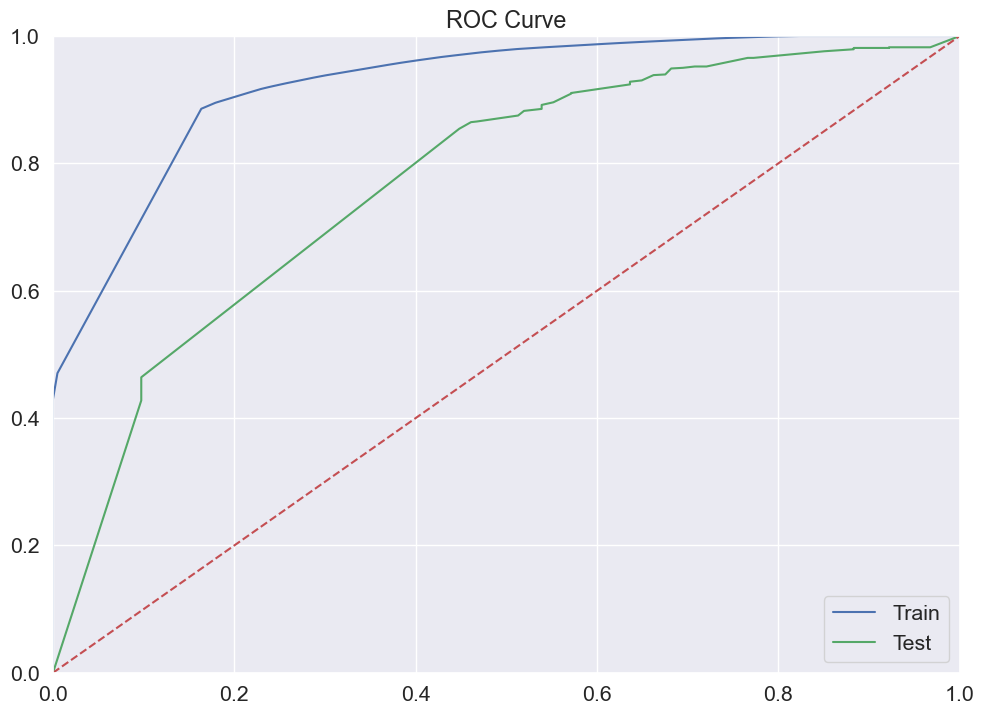

In [36]:
# Plotting roc curve on Train Data
y_predict_train = decisiontree_model_final.predict_proba(X_train_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_tfidf, y_predict_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
y_predict_test = decisiontree_model_final.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_tfidf, y_predict_test)
plt.plot(fpr, tpr, 'r', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'y--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

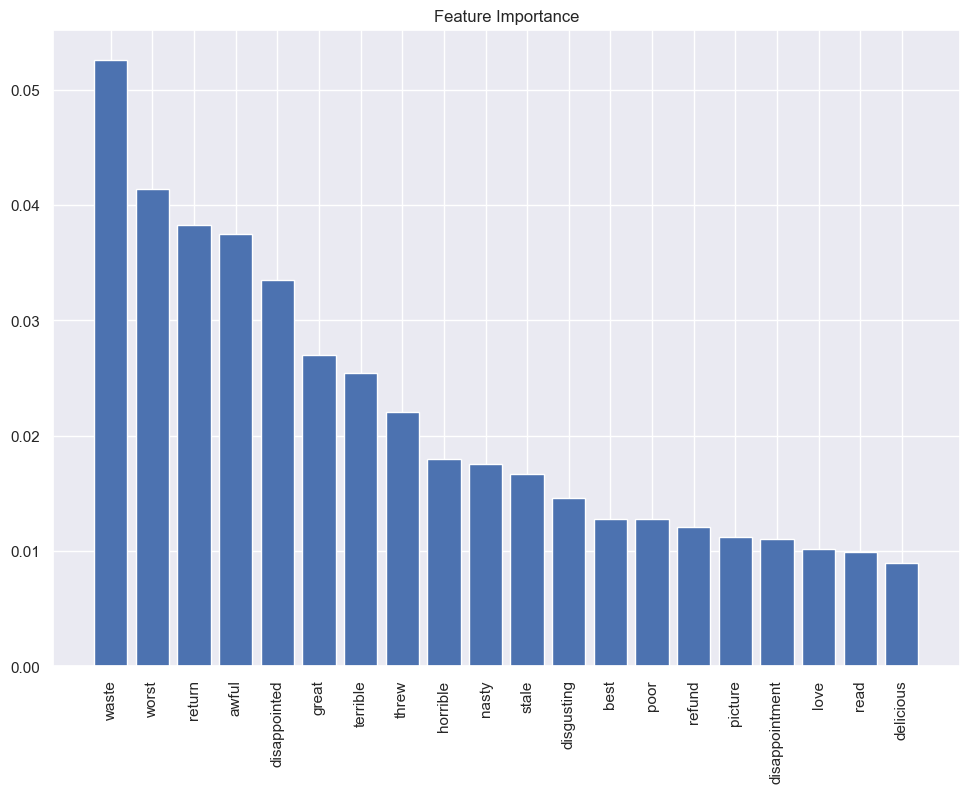

In [38]:

# Calculate feature importances 
feature_importances = decisiontree_model_final.feature_importances_
indices = np.argsort(feature_importances,kind='quicksort')[::-1][:15]
# Get the feature names 
feature_names = tf_idf_vect.get_feature_names_out()

sns.set(rc={'figure.figsize':(15,10)})
# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance(Words)")
# Add bars
plt.bar(range(15), feature_importances[indices])
# Add feature feature_names as x-axis labels
feature_names = np.array(feature_names)
plt.xticks(range(15), feature_names[indices], rotation=90)
# Show plot
plt.show()

In [39]:
# Avg W2V

In [42]:
# split the dataset
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y_data, test_size=0.1, random_state=234)

In [43]:

# using GridSearchCV 
grid_search = GridSearchCV(decision_tree_model,parameters,scoring='roc_auc',cv=10,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_w2v,y_train_w2v)
print("best max depth :",grid_search.best_params_['max_depth'])
print("best min sample split :",grid_search.best_params_['min_samples_split'])
print("best roc auc score : %.3f"%(grid_search.best_score_))

Best Max Depth Value: 25
Best Min Sample Split Value: 500
Best ROC AUC Score: 0.68445


In [44]:
best_max_depth = grid_search.best_params_['max_depth']
best_min_sample_split = grid_search.best_params_['min_samples_split']

decisiontree_model_final = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_sample_split)
decisiontree_model_final.fit(X_train_w2v,y_train_w2v)

y_pred = decisiontree_model_final.predict_proba(X_test_w2v)[:,1]

auc_score = roc_auc_score(y_test_w2v, y_pred)
print("\n Roc_Auc_Score on test set is " ,(auc_score))


**** Test roc_auc_score is 0.707684 ****


In [45]:
# seaborn heatmap on Train Data

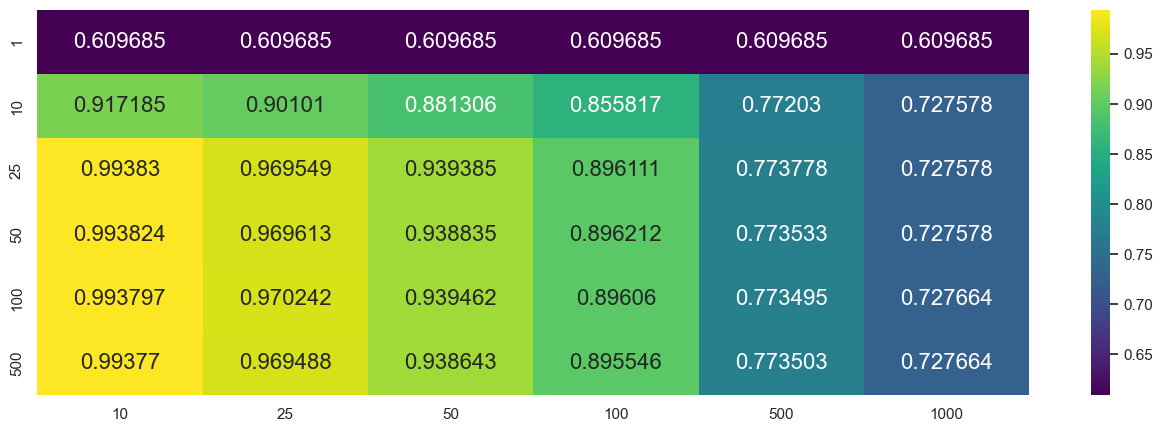

In [46]:
# train data
mean_score=np.array(grid_search.cv_results_['mean_train_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

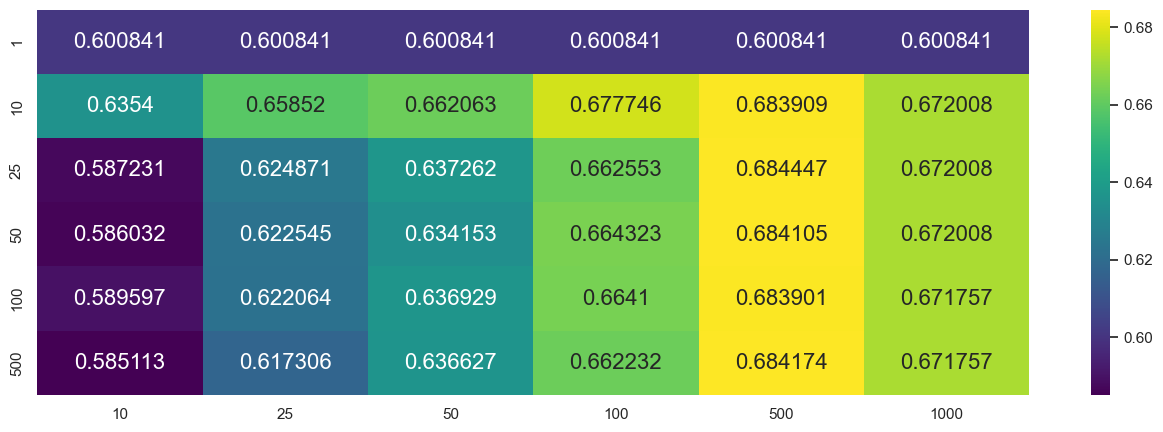

In [47]:
# test data
mean_score=np.array(grid_search.cv_results_['mean_test_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

[[  21 1391]
 [   9 8613]]


<Axes: >

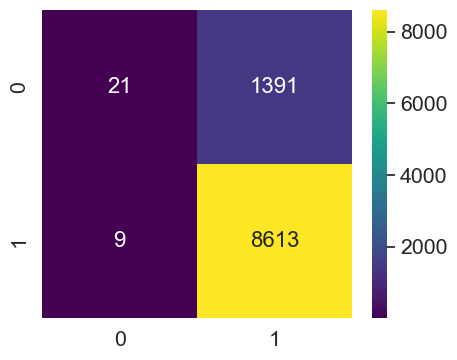

In [49]:
# confusion matrix of trained set
y_predict = decisiontree_model_final.predict(X_train_w2v)
cm = confusion_matrix(y_train_w2v, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

[[  0 154]
 [  1 960]]


<Axes: >

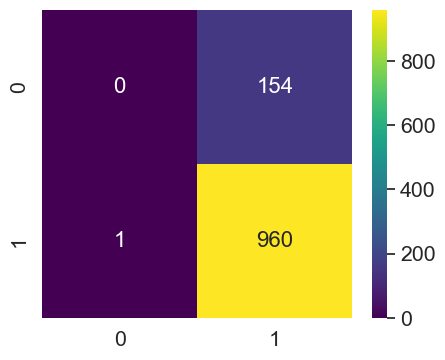

In [48]:
# confusion matrix of test set
y_predict = decisiontree_model_final.predict(X_test_w2v)
cm = confusion_matrix(y_test_w2v, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

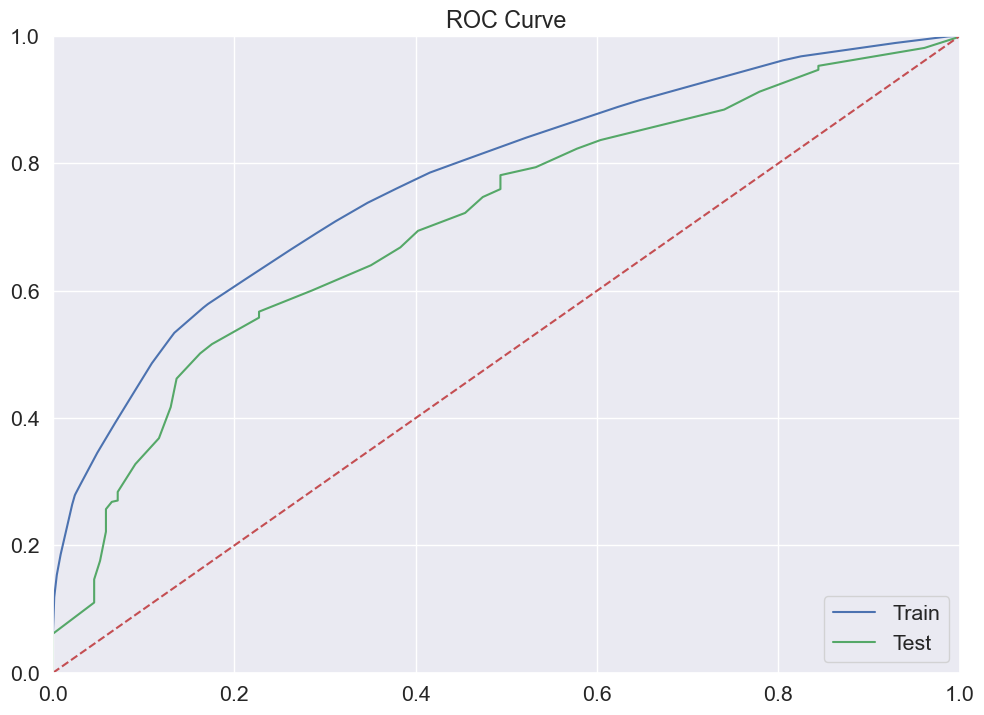

In [50]:
# Plotting roc curve on Train Data
y_predict_train = decisiontree_model_final.predict_proba(X_train_w2v)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_w2v, y_predict_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
y_predict_test = decisiontree_model_final.predict_proba(X_test_w2v)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_w2v, y_predict_test)
plt.plot(fpr, tpr, 'r', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'y--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [51]:
# tfidf w2v

In [53]:
# split the dataset
X_train_tfw2v, X_test_tfw2v, y_train_tfw2v, y_test_tfw2v = train_test_split(
    X_tfw2v, y_data, test_size=0.1, random_state=234)

In [54]:

# using GridSearchCV 
grid_search = GridSearchCV(decision_tree_model,parameters,scoring='roc_auc',cv=10,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_tfw2v,y_train_tfw2v)
print("best max depth :",grid_search.best_params_['max_depth'])
print("best min sample split :",grid_search.best_params_['min_samples_split'])
print("best roc auc score : %.3f"%(grid_search.best_score_))

Best Max Depth Value: 25
Best Min Sample Split Value: 500
Best ROC AUC Score: 0.65730


In [55]:
best_max_depth = grid_search.best_params_['max_depth']
best_min_sample_split = grid_search.best_params_['min_samples_split']

decisiontree_model_final = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_sample_split)
decisiontree_model_final.fit(X_train_tfw2v,y_train_tfw2v)

y_pred = decisiontree_model_final.predict_proba(X_test_tfw2v)[:,1]

auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print("\n Roc_Auc_Score on test set is " ,(auc_score))


**** Test roc_auc_score is 0.709711 ****


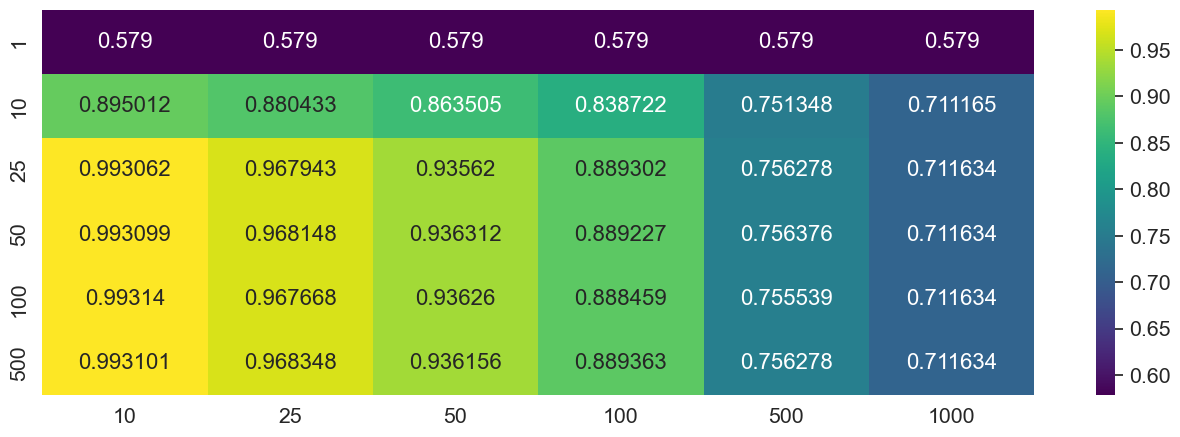

In [56]:
# train data
mean_score=np.array(grid_search.cv_results_['mean_train_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

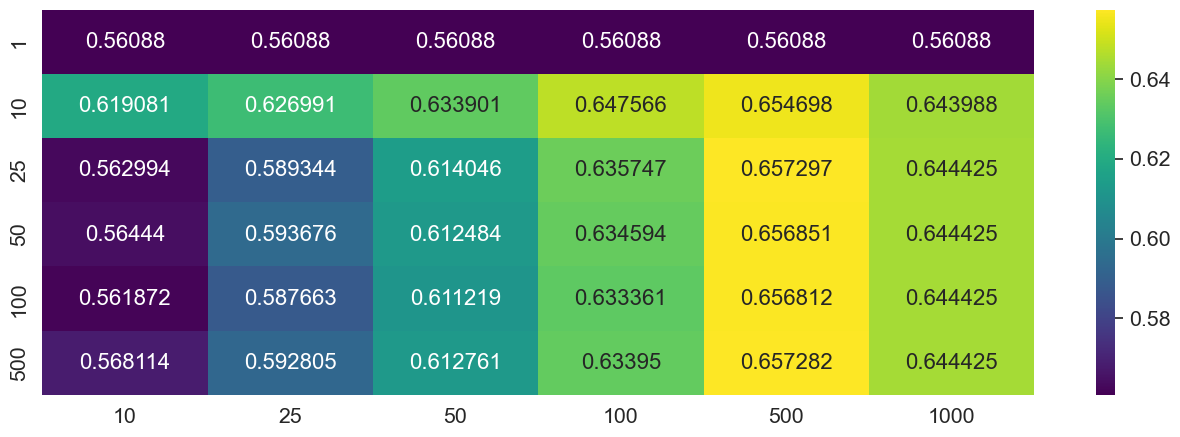

In [57]:
# test data
mean_score=np.array(grid_search.cv_results_['mean_test_score'])
arr = np.reshape(mean_score, (6,6))
data = pd.DataFrame(arr, index=parameters['max_depth'], columns=parameters['min_samples_split'])
plt.figure(figsize = (12,5))
sns.heatmap(data, annot=True, annot_kws={"size": 12}, cmap='viridis')
plt.show()

[[  2 152]
 [ 10 951]]


<Axes: >

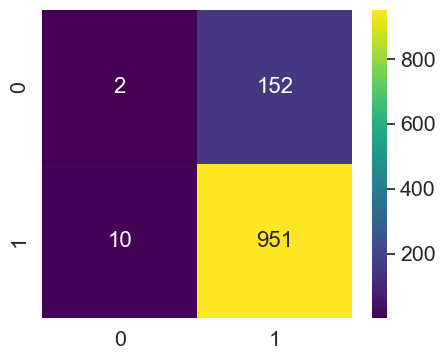

In [58]:
# confusion matrix of trained set
y_predict = decisiontree_model_final.predict(X_train_tfw2v)
cm = confusion_matrix(y_train_tfw2v, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

[[  55 1357]
 [  30 8592]]


<Axes: >

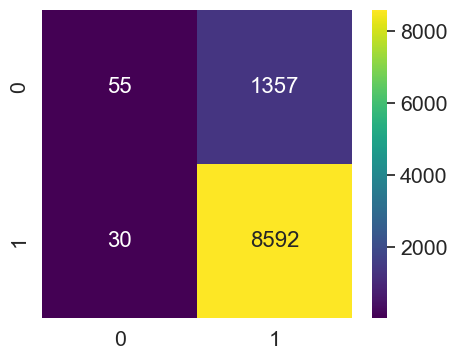

In [59]:
# confusion matrix of test set
y_predict = decisiontree_model_final.predict(X_test_tfw2v)
cm = confusion_matrix(y_test_tfw2v, y_predict)
print(cm)
plt.figure(figsize = (6,3))
df_cm = pd.DataFrame(cm)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g',cmap='viridis')

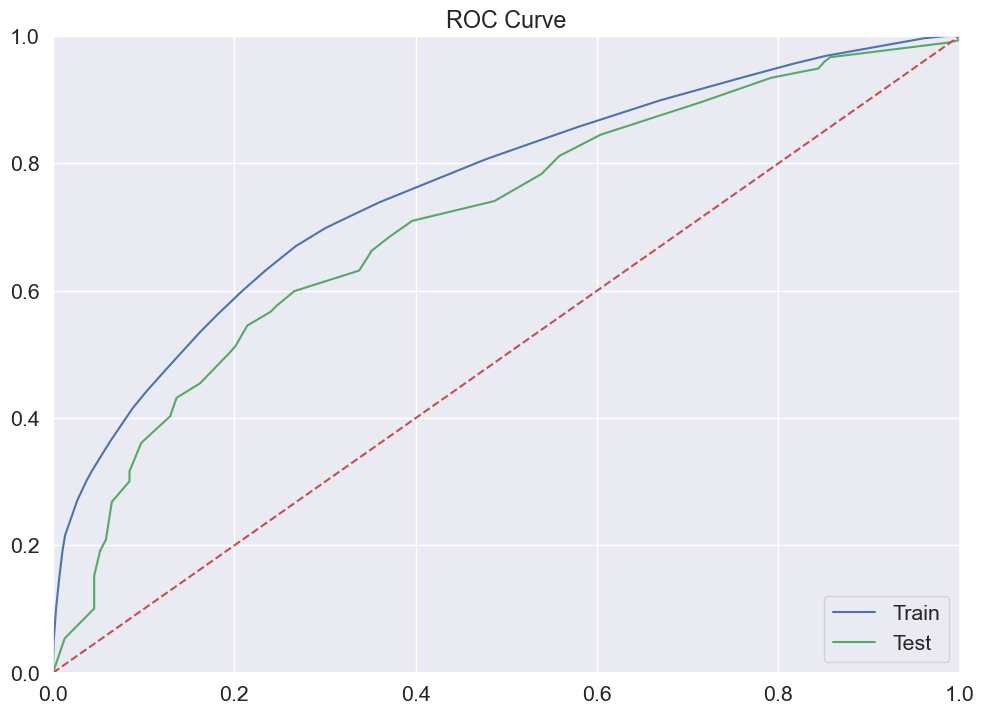

In [60]:
# Plotting roc curve on Train Data
y_predict_train = decisiontree_model_final.predict_proba(X_train_tfw2v)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_tfw2v, y_predict_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
y_predict_test = decisiontree_model_final.predict_proba(X_test_tfw2v)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_tfw2v, y_predict_test)
plt.plot(fpr, tpr, 'r', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'y--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [61]:
# conclusion